In [7]:
%cd ~/projects/kaggle/quora

/Users/trung/projects/kaggle/quora


In [8]:
import cPickle
import pandas as pd
import numpy as np
import gensim
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
from gensim.models import KeyedVectors

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Download pre-trained word vector models.

In [5]:
!cd ~/projects/kaggle/quora/data/raw
!wget --no-check-certificate http://www-nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!rm glove.840B.300d.zip
!wget http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!cd ../..

--2017-03-24 16:37:05--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu... 171.64.67.140
Connecting to www-nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 
  HTTP/1.1 302 Found
  Date: Fri, 24 Mar 2017 05:37:06 GMT
  Server: Apache/2.2.15 (CentOS)
  Location: https://www-nlp.stanford.edu/data/glove.840B.300d.zip
  Content-Length: 323
  Connection: close
  Content-Type: text/html; charset=iso-8859-1
Location: https://www-nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2017-03-24 16:37:05--  https://www-nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to www-nlp.stanford.edu|171.64.67.140|:443... connected.
ERROR: no certificate subject alternative name matches
	requested host name 'www-nlp.stanford.edu'.
To connect to www-nlp.stanford.edu insecurely, use `--no-check-certificate'.
unzip:  cannot find or open glove.840B.300d.zip, glove.840B.300d.zip.zip or glove.840B.300d.zip.ZIP.
rm: glove.840B.300d

In [10]:
from src.features_generator import FeaturesGenerator

In [11]:
gen = FeaturesGenerator()
wv_loc = 'data/raw/GoogleNews-vectors-negative300.bin.gz'

In [6]:
# try word2vec pre-trained model
model = KeyedVectors.load_word2vec_format(wv_loc, binary=True)

In [13]:
variant = 'data/variant1/'
inp_train = variant+'train_orig.csv'
inp_test = variant+'test_orig.csv'
d = pd.read_csv(inp_train)
dt = pd.read_csv(inp_test)

In [15]:
X = gen.features_set1(d, model)
X_test = gen.features_set1(dt, model)

In [9]:
X.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], inplace=True, axis=1)
print(X.columns)

Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'diff_chars', u'len_word_q1', u'len_word_q2', u'diff_words',
       u'common_words', u'fuzz_qratio', u'fuzz_WRatio', u'fuzz_partial_ratio',
       u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
       u'fuzz_token_set_ratio', u'fuzz_token_sort_ratio', u'wmd',
       u'cosine_distance', u'cityblock_distance', u'jaccard_distance',
       u'canberra_distance', u'euclidean_distance', u'braycurtis_distance',
       u'skew_q1vec', u'skew_q2vec', u'ratio_skew', u'kur_q1vec', u'kur_q2vec',
       u'ratio_kur'],
      dtype='object')


In [10]:
X_test.drop(['question1', 'question2'], inplace=True, axis=1)
X_test.columns

Index([u'test_id', u'len_q1', u'len_q2', u'diff_len', u'len_char_q1',
       u'len_char_q2', u'diff_chars', u'len_word_q1', u'len_word_q2',
       u'diff_words', u'common_words', u'fuzz_qratio', u'fuzz_WRatio',
       u'fuzz_partial_ratio', u'fuzz_partial_token_set_ratio',
       u'fuzz_partial_token_sort_ratio', u'fuzz_token_set_ratio',
       u'fuzz_token_sort_ratio', u'wmd', u'cosine_distance',
       u'cityblock_distance', u'jaccard_distance', u'canberra_distance',
       u'euclidean_distance', u'braycurtis_distance', u'skew_q1vec',
       u'skew_q2vec', u'ratio_skew', u'kur_q1vec', u'kur_q2vec', u'ratio_kur'],
      dtype='object')

## Optional step - only applicable to variants without stemming

In [9]:
q1_vecs, q2_vecs = gen.questions_to_vectors_sum(d, model)
d1 = gen.distances(q1_vecs, q2_vecs)

404290it [01:49, 3704.71it/s]0, 1473.58it/s]
404290it [01:51, 3613.57it/s]


calculating distances between document vectors


In [18]:
q1_vecs, q2_vecs = gen.questions_to_vectors_sum(dt, model)
d1_test = gen.distances(q1_vecs, q2_vecs)

2345796it [10:02, 3896.13it/s], 1907.81it/s]
2345796it [10:31, 3714.69it/s]


calculating distances between document vectors


In [22]:
X = pd.concat([X, d1], axis=1)
X_test = pd.concat([X_test, d1_test], axis=1)

## Output features

In [25]:
X.to_csv(variant+'train_set1.csv', index=False)
X_test.to_csv(variant+'test_set1.csv', index=False)

In [11]:
X.loc[0:5,'len_q1':'ratio_kur']

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,diff_chars,len_word_q1,len_word_q2,diff_words,common_words,...,jaccard_distance,canberra_distance,euclidean_distance,braycurtis_distance,skew_q1vec,skew_q2vec,ratio_skew,kur_q1vec,kur_q2vec,ratio_kur
0,66,57,9,20,20,0,14,12,2,10,...,1,88.528486,0.338093,0.169767,0.044441,-0.050134,-0.886451,0.070844,0.318994,0.222085
1,51,88,-37,21,29,-8,8,13,-5,4,...,1,156.666351,0.847736,0.453438,0.050607,0.022456,2.253561,-0.291523,-0.294550,0.989724
2,73,59,14,25,24,1,14,10,4,3,...,1,142.214167,0.682938,0.358818,0.006170,0.052742,0.116976,-0.246385,-0.554404,0.444414
3,50,65,-15,19,26,-7,11,9,2,0,...,1,196.603820,1.147891,0.723568,0.143320,0.103355,1.386681,-0.024968,-0.330020,0.075655
4,76,39,37,25,18,7,13,7,6,2,...,1,158.124489,0.814565,0.453041,-0.136526,0.153758,-0.887929,0.110914,-0.303999,-0.364851
5,86,90,-4,26,27,-1,16,16,0,7,...,1,139.274609,0.665376,0.354512,-0.019419,0.050563,-0.384062,0.009835,-0.115832,-0.084910


## Classification model

Let's build a classification model on this features set. We can ensemble results (or potentially stack models) later.

In [6]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from __future__ import print_function, division

In [7]:
def resample(x_train, y_train):
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    # Now we oversample the negative class
    # There is likely a much more elegant way to do this...
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print(len(pos_train) / (len(pos_train) + len(neg_train)))

    x_train = pd.concat([pos_train, neg_train])
    y_train = np.hstack(((np.ones(len(pos_train))), np.zeros(len(neg_train))))
    return x_train, y_train

y = d.is_duplicate.values
X = pd.read_csv('data/train_features1.csv').loc[:, 'len_q1':'kur_q2vec']
print(X.shape)
print(sum(y==1)*1.0/len(y))

(404290, 26)
0.369197853026


In [32]:
X, y = resample(X, y)
print(sum(y == 1) *1.0 / len(y))
X.columns

0.191243661001
0.191243661001


Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'len_word_q1', u'len_word_q2', u'common_words', u'fuzz_qratio',
       u'fuzz_WRatio', u'fuzz_partial_ratio', u'fuzz_partial_token_set_ratio',
       u'fuzz_partial_token_sort_ratio', u'fuzz_token_set_ratio',
       u'fuzz_token_sort_ratio', u'wmd', u'cosine_distance',
       u'cityblock_distance', u'jaccard_distance', u'canberra_distance',
       u'euclidean_distance', u'braycurtis_distance', u'skew_q1vec',
       u'skew_q2vec', u'kur_q1vec', u'kur_q2vec'],
      dtype='object')

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1110)
X_train.shape, X_val.shape

((624388, 26), (156098, 26))

Cross-validation training to get the best parameters

In [102]:
# train on validation to get the best parameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=128, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=3000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='logloss',
          early_stopping_rounds=50
         )

[1]	valid_0's binary_logloss: 0.668976	valid_1's binary_logloss: 0.669079
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's binary_logloss: 0.647579	valid_1's binary_logloss: 0.647714
[3]	valid_0's binary_logloss: 0.627538	valid_1's binary_logloss: 0.627777
[4]	valid_0's binary_logloss: 0.609567	valid_1's binary_logloss: 0.609885
[5]	valid_0's binary_logloss: 0.592896	valid_1's binary_logloss: 0.593289
[6]	valid_0's binary_logloss: 0.577789	valid_1's binary_logloss: 0.578256
[7]	valid_0's binary_logloss: 0.563819	valid_1's binary_logloss: 0.564344
[8]	valid_0's binary_logloss: 0.550912	valid_1's binary_logloss: 0.55151
[9]	valid_0's binary_logloss: 0.53915	valid_1's binary_logloss: 0.539779
[10]	valid_0's binary_logloss: 0.52809	valid_1's binary_logloss: 0.528761
[11]	valid_0's binary_logloss: 0.517857	valid_1's binary_logloss: 0.518589
[12]	valid_0's binary_logloss: 0.508302	valid_1's binary_logloss: 0.50909
[13]	valid_0's binary_logloss: 0.49952	valid_1's binary_log

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=3000, nthread=-1, num_leaves=128,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

Evaluation

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from matplotlib import pyplot as plt
def evaluate(label, pred_prob, pred_label):
    plt.hist(pred_prob[label == 1])
    plt.title('positive class')
    plt.figure()
    plt.hist(pred_prob[label == 0])
    plt.title('negative class')

    print(confusion_matrix(label, pred_label  n,kl      ))
    print(classification_report(label, pred_label, target_names=['not duplicate', 'duplicate']))
    print(roc_auc_score(label, pred_prob))

In [103]:
val_prob = model.predict_proba(X_val, num_iteration=model.best_iteration)[:,1]
val_label = model.predict(X_val, num_iteration=model.best_iteration)

[[124668   1455]
 [ 17788  12187]]
               precision    recall  f1-score   support

not duplicate       0.88      0.99      0.93    126123
    duplicate       0.89      0.41      0.56     29975

  avg / total       0.88      0.88      0.86    156098

0.922180070494


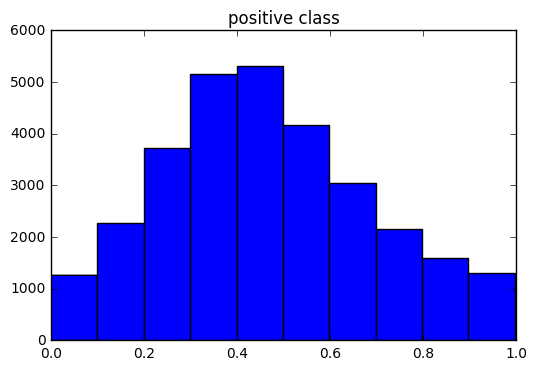

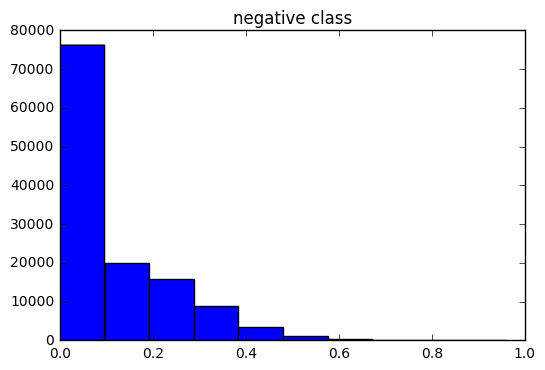

In [104]:
# 3000 trees, num_leaves = 128
evaluate(y_val, val_prob, val_label)

[[124492   1631]
 [ 19230  10745]]
               precision    recall  f1-score   support

not duplicate       0.87      0.99      0.92    126123
    duplicate       0.87      0.36      0.51     29975

  avg / total       0.87      0.87      0.84    156098

0.906963999565


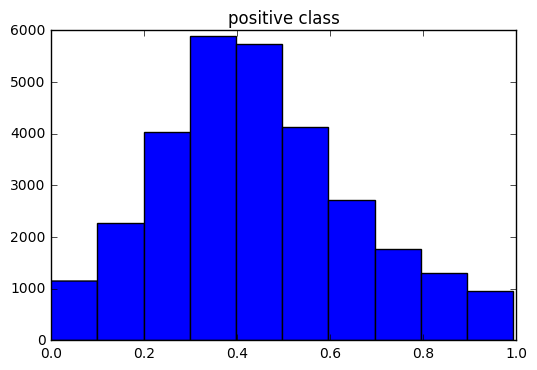

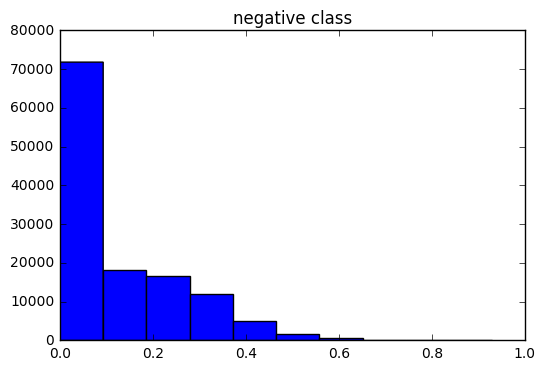

In [101]:
# 2000 trees, depth = 7
evaluate(y_val, val_prob, val_label)

[[123928   2195]
 [ 22905   7070]]
               precision    recall  f1-score   support

not duplicate       0.84      0.98      0.91    126123
    duplicate       0.76      0.24      0.36     29975

  avg / total       0.83      0.84      0.80    156098

0.862348999541


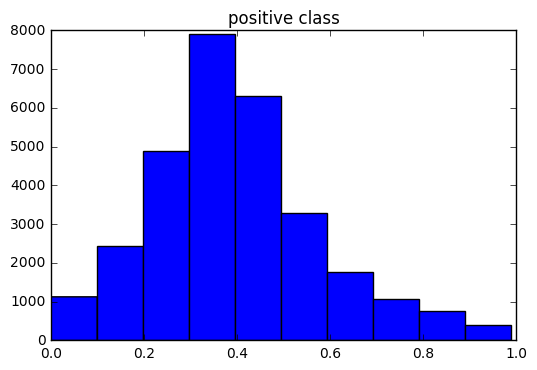

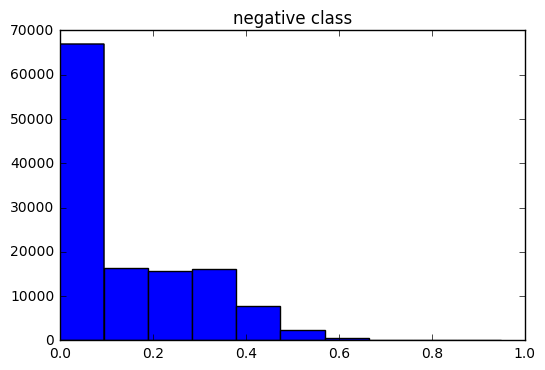

In [43]:
# 2000 trees? num_leaves = 64 or 32
evaluate(y_val, val_prob, val_label)

Train on all data

In [47]:
# now train on full data set
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=32, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=2000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)

In [48]:
model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss')

[1]	valid_0's binary_logloss: 0.669682
[2]	valid_0's binary_logloss: 0.648859
[3]	valid_0's binary_logloss: 0.629407
[4]	valid_0's binary_logloss: 0.611966
[5]	valid_0's binary_logloss: 0.595758
[6]	valid_0's binary_logloss: 0.581061
[7]	valid_0's binary_logloss: 0.567507
[8]	valid_0's binary_logloss: 0.55499
[9]	valid_0's binary_logloss: 0.543614
[10]	valid_0's binary_logloss: 0.532897
[11]	valid_0's binary_logloss: 0.523052
[12]	valid_0's binary_logloss: 0.513861
[13]	valid_0's binary_logloss: 0.505343
[14]	valid_0's binary_logloss: 0.49747
[15]	valid_0's binary_logloss: 0.49029
[16]	valid_0's binary_logloss: 0.483491
[17]	valid_0's binary_logloss: 0.47706
[18]	valid_0's binary_logloss: 0.4711
[19]	valid_0's binary_logloss: 0.465584
[20]	valid_0's binary_logloss: 0.460481
[21]	valid_0's binary_logloss: 0.455641
[22]	valid_0's binary_logloss: 0.45105
[23]	valid_0's binary_logloss: 0.446834
[24]	valid_0's binary_logloss: 0.44285
[25]	valid_0's binary_logloss: 0.439137
[26]	valid_0's bi

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=2000, nthread=-1, num_leaves=32,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

Prediction

In [24]:
X_test = pd.read_csv('data/test_features1.csv').loc[:, 'len_q1':'kur_q2vec']

In [49]:
y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration)
sub = pd.DataFrame({'test_id': dt.test_id, 'is_duplicate': y_pred[:,1]})
sub.to_csv('results/features1_sampled.csv', index=False)

   is_duplicate  test_id
0      0.009466        0
1      0.588631        1
2      0.484153        2
3      0.005191        3
4      0.458178        4
   is_duplicate  test_id
0      0.009441        0
1      0.378149        1
2      0.356240        2
3      0.002246        3
4      0.281695        4


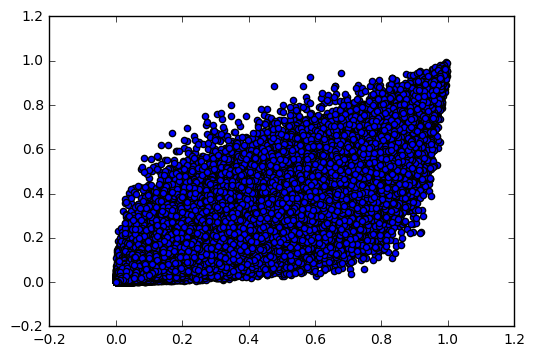

In [73]:
# Comparing sampled vs. not sampled predictions
p1 = pd.read_csv('results/features1_notsampled.csv')
p2 = pd.read_csv('results/features1_sampled.csv')
print(p1.head())
print(p2.head())

(array([  4.50000000e+01,   2.70000000e+02,   2.68300000e+03,
          7.39860000e+04,   1.42596700e+06,   5.36378000e+05,
          2.68818000e+05,   3.55440000e+04,   2.02700000e+03,
          7.80000000e+01]),
 array([-0.50431221, -0.38157825, -0.25884428, -0.13611032, -0.01337636,
         0.1093576 ,  0.23209156,  0.35482553,  0.47755949,  0.60029345,
         0.72302741]),
 <a list of 10 Patch objects>)

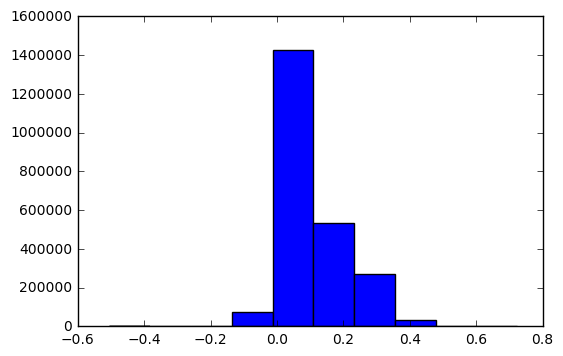

In [74]:
plt.hist(p1.is_duplicate - p2.is_duplicate)